In [47]:
# Cargamos librerías
# Librería para representacion de grafos
import networkx as nx 
from torch_geometric.utils.convert import to_networkx


import torch.nn.functional as F

# Librería con modelo GNN y utilidades

from utils import *
from uci.uci_data import *
from models.gnn_model import get_gnn
from models.prediction_model import MLPNet
from utils.utils import build_optimizer


In [48]:
# Definimos una funcion para pasar parametros a las distintas funciones implementadas por los autores

class paso_parametros:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

# Concrete

(Mirar).

In [49]:
# Carga datos de dataset Housing
uci_path='/notebooks/datasets'
df_np = np.loadtxt(uci_path+'/{}/data.txt'.format('concrete'))
df_y = pd.DataFrame(df_np[:, -1:])
df_X = pd.DataFrame(df_np[:, :-1])

#Definimos los parámetros del grafo
node_mode=0
train_edge=0.7
split_sample=0.
split_by='y'
train_y=0.7
seed=np.random.rand()
normalize=True

#Generamos el grafo
data = get_data(df_X, df_y, node_mode, train_edge, split_sample, 
                    split_by, train_y, seed,normalize)


In [50]:
class paso_parametros:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

#Pasamos los distintos parámetros del modelo        
parametros_modelo = {
    "model_types":'EGSAGE_EGSAGE_EGSAGE',
    "norm_embs":None,
    "post_hiddens":None,
    "node_dim": 64,
    "edge_dim":64,
    "edge_mode":1,
    "gnn_activation":'relu',
    "concat_states":False,
    "dropout":0.,
    "aggr":'mean'
}    
device='cuda'

#Generamos el modelo y lo mostramos
model = get_gnn(data, paso_parametros(**parametros_modelo)).to(device)

# Imprimimos el modelo
print(model)

['EGSAGE', 'EGSAGE', 'EGSAGE'] [True, True, True] [64]
GNNStack(
  (convs): ModuleList(
    (0): EGraphSage(
      (message_lin): Linear(in_features=9, out_features=64, bias=True)
      (agg_lin): Linear(in_features=72, out_features=64, bias=True)
      (message_activation): ReLU()
      (update_activation): ReLU()
    )
    (1): EGraphSage(
      (message_lin): Linear(in_features=128, out_features=64, bias=True)
      (agg_lin): Linear(in_features=128, out_features=64, bias=True)
      (message_activation): ReLU()
      (update_activation): ReLU()
    )
    (2): EGraphSage(
      (message_lin): Linear(in_features=128, out_features=64, bias=True)
      (agg_lin): Linear(in_features=128, out_features=64, bias=True)
      (message_activation): ReLU()
      (update_activation): ReLU()
    )
  )
  (node_post_mlp): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (1): Linear(in

In [51]:
# Esta red neuronal asigna valores a los arcos
impute_hiddens='64'
impute_hiddens = list(map(int,impute_hiddens.split('_')))
input_dim = parametros_modelo['node_dim'] * 2
output_dim = 1
impute_activation='relu'
impute_model = MLPNet(input_dim, output_dim,
                            hidden_layer_sizes=impute_hiddens,
                            hidden_activation=impute_activation,
                            dropout=parametros_modelo['dropout']).to(device)
impute_model


MLPNet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=64, out_features=1, bias=True)
      (1): Identity()
    )
  )
)

In [52]:
#Podemos ver los parametros de los dos modelos.
print("Parametros del modelo GNN")
print("-----------")
for name, param in model.named_parameters():
    if param.requires_grad:
        print (name,param.shape)
print("+++++++++++")
print("Parametros del modelo Impute model")
print("-----------")
for name, param in impute_model.named_parameters():
    if param.requires_grad:
        print (name, param.shape)

#Unimos los parametros
trainable_parameters = list(model.parameters()) + list(impute_model.parameters())

Parametros del modelo GNN
-----------
convs.0.message_lin.weight torch.Size([64, 9])
convs.0.message_lin.bias torch.Size([64])
convs.0.agg_lin.weight torch.Size([64, 72])
convs.0.agg_lin.bias torch.Size([64])
convs.1.message_lin.weight torch.Size([64, 128])
convs.1.message_lin.bias torch.Size([64])
convs.1.agg_lin.weight torch.Size([64, 128])
convs.1.agg_lin.bias torch.Size([64])
convs.2.message_lin.weight torch.Size([64, 128])
convs.2.message_lin.bias torch.Size([64])
convs.2.agg_lin.weight torch.Size([64, 128])
convs.2.agg_lin.bias torch.Size([64])
node_post_mlp.0.0.weight torch.Size([64, 64])
node_post_mlp.0.0.bias torch.Size([64])
node_post_mlp.1.weight torch.Size([64, 64])
node_post_mlp.1.bias torch.Size([64])
edge_update_mlps.0.0.weight torch.Size([64, 129])
edge_update_mlps.0.0.bias torch.Size([64])
edge_update_mlps.1.0.weight torch.Size([64, 192])
edge_update_mlps.1.0.bias torch.Size([64])
edge_update_mlps.2.0.weight torch.Size([64, 192])
edge_update_mlps.2.0.bias torch.Size([6

# Entrenamiento

In [53]:
epochs=20000
known=0.7 #Probabilidad de conocer el valor del atributo del arco (rdrop=1-known)

In [54]:
# Organizamos los datos del entrenamiento

x = data.x.clone().detach().to(device)
all_train_edge_index = data.train_edge_index.clone().detach().to(device)
all_train_edge_attr = data.train_edge_attr.clone().detach().to(device)
all_train_labels = data.train_labels.clone().detach().to(device)
train_edge_index, train_edge_attr, train_labels = all_train_edge_index, \
                                                  all_train_edge_attr, \
                                                  all_train_labels

In [55]:
########################### NO ejecutar 


#Parametros del optimizador.
parametros_opt = {
    "opt":'adam',
    "weight_decay":0.,
    "lr":0.001,
    "opt_scheduler":'none',
    "opt_decay_step":1000,
    "opt_decay_rate":0.9
}    
# build optimizer
scheduler, opt = build_optimizer(paso_parametros(**parametros_opt), trainable_parameters)


for epoch in range(epochs):
    model.train()
    impute_model.train()
    
    # Obtenemos los arcos para los que sabemos el valor de su atributo
    known_mask = get_known_mask(known, int(train_edge_attr.shape[0] / 2)).to(device)
    double_known_mask = torch.cat((known_mask, known_mask), dim=0)
    known_edge_index, known_edge_attr = mask_edge(train_edge_index, train_edge_attr, 
                                                  double_known_mask, True)
    #################
    opt.zero_grad()
    # Calculamos el embeding del nodo
    x_embd = model(x, known_edge_attr, known_edge_index) # Dimensiones 519x64
    # Predecimos la etiqueta del arco
    pred = impute_model([x_embd[train_edge_index[0]], x_embd[train_edge_index[1]]]) #Dimensiones 9318x1
    pred_train = pred[:int(train_edge_attr.shape[0] / 2),0] # Dimensiones 4659
    # Comparamos con la etiqueta real del arco
    label_train = train_labels
    loss = F.mse_loss(pred_train, label_train)
    if epoch%500==1:
        print(loss)
    loss.backward()
    opt.step()
    
print("Loss final:{}".format(loss))

tensor(0.1305, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0213, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0068, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0071, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0071, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0066, device='cuda:0', grad_fn=<MseLossBackward

In [56]:
#Grabamos el modelo #### Dejamos comentado
#torch.save(model.state_dict(), uci_path+'/concrete/saved_model/model')
#torch.save(impute_model.state_dict(), uci_path+'/concrete/saved_model/impute_model')

In [ ]:
#Cargado el modelo
model.load_state_dict(torch.load(uci_path+'/concrete/saved_model/model',
                                 map_location=torch.device(device)))
impute_model.load_state_dict(torch.load(uci_path+'/concrete/saved_model/impute_model',
                                        map_location=torch.device(device)))

<All keys matched successfully>

In [57]:
#Evaluamos el modelo
x = data.x.clone().detach().to(device)
all_train_edge_index = data.train_edge_index.clone().detach().to(device)
all_train_edge_attr = data.train_edge_attr.clone().detach().to(device)
all_train_labels = data.train_labels.clone().detach().to(device)
test_input_edge_index = all_train_edge_index
test_input_edge_attr = all_train_edge_attr
test_edge_index = data.test_edge_index.clone().detach().to(device)
test_edge_attr = data.test_edge_attr.clone().detach().to(device)
test_labels = data.test_labels.clone().detach().to(device)

model.eval()
impute_model.eval()
with torch.no_grad():
    x_embd = model(x, test_input_edge_attr, test_input_edge_index)
    pred = impute_model([x_embd[test_edge_index[0], :], x_embd[test_edge_index[1], :]])
    pred_test = pred[:int(test_edge_attr.shape[0] / 2),0]
    label_test = test_labels
    mse = F.mse_loss(pred_test, label_test)
    test_rmse = np.sqrt(mse.item())
    l1 = F.l1_loss(pred_test, label_test)
    test_l1 = l1.item()
print("MSE: {} RMSE: {} MAE: {}".format(mse.item(), test_rmse,test_l1))

# Guardamos MAE y RMSE en una lista
val_GRAPE=[test_l1, test_rmse]

MSE: 0.01805456541478634 RMSE: 0.13436727806570445 MAE: 0.08584008365869522


In [58]:
# Por curiosidad mostramos como serian las 5 primeras etiquetas vs sus prediciones
print(label_test[0:5].tolist())
print(pred_test[0:5].tolist())

[0.0, 0.07417582720518112, 0.39649415016174316, 0.38081395626068115, 0.7390109896659851]
[-0.010777436196804047, 0.11525193601846695, 0.3995210826396942, 0.3706745505332947, 0.20539426803588867]


# ¿Estos valores son buenos?

Comparamos con otros métodos de imputacion de valores

In [59]:
# Utilizamos los parametros para los que sabemos sus valores
train_edge_mask = data.train_edge_mask.numpy()

#Obtenemos las matrices de parametros completos e incompletos
from utils.utils import construct_missing_X_from_mask
X, X_incomplete = construct_missing_X_from_mask(train_edge_mask, data.df_X)

In [60]:
#Vemos un ejemplo con la primera observacion
print("Dataset completo: \n{}".format(X[0][0:5]))
print("Dataset incompleto: \n{}".format(X_incomplete[0][0:5]))

Dataset completo: 
[1.         0.         0.         0.32108626 0.07763975]
Dataset incompleto: 
[1.                nan 0.         0.32108626 0.07763975]


In [61]:
# Para los distintos métodos de imputacion, los autores utilizan
# la libreria "fancyimpute" con distintos métodos

from fancyimpute import SimpleFill, KNN, IterativeImputer, IterativeSVD, SoftImpute

# Función para imputar valores
def baseline_inpute(X_incomplete, method='mean',level=0):

    if method == 'mean':
        X_filled_mean = SimpleFill().fit_transform(X_incomplete)
        return X_filled_mean
    elif method == 'knn':
        k = [3,10,50][level]
        X_filled_knn = KNN(k=k, verbose=False).fit_transform(X_incomplete)
        return X_filled_knn
    elif method == 'svd':
        rank = [np.ceil((X_incomplete.shape[1]-1)/10),np.ceil((X_incomplete.shape[1]-1)/5),X_incomplete.shape[1]-1][level]
        X_filled_svd = IterativeSVD(rank=int(rank),verbose=False).fit_transform(X_incomplete)
        return X_filled_svd
    elif method == 'mice':
        max_iter = [3,10,50][level]
        X_filled_mice = IterativeImputer(max_iter=max_iter).fit_transform(X_incomplete)
        return X_filled_mice
    elif method == 'spectral':
        # default value for the sparsity level is with respect to the maximum singular value,
        # this is now done in a heuristic way
        sparsity = [0.5,None,3][level]
        X_filled_spectral = SoftImpute(shrinkage_value=sparsity).fit_transform(X_incomplete)
        return X_filled_spectral
    else:
        raise NotImplementedError


In [62]:
#Como primer ejemplo, usamos la media para imputar los valores.
method='mean'
level=0
X_filled = baseline_inpute(X_incomplete, method,level)

In [63]:
print("Dataset completo: \n{}".format(X[0][0:6]))
print("Dataset incompleto: \n{}".format(X_incomplete[0][0:6]))
print("Dataset relleno: \n{}".format(X_filled[0][0:6]))

Dataset completo: 
[1.         0.         0.         0.32108626 0.07763975 0.69476744]
Dataset incompleto: 
[1.                nan 0.         0.32108626 0.07763975 0.69476744]
Dataset relleno: 
[1.         0.20666578 0.         0.32108626 0.07763975 0.69476744]


In [64]:
mask = np.isnan(X_incomplete)
diff = X[mask] - X_filled[mask]
mae = np.mean(np.abs(diff))
rmse = np.sqrt(np.mean(diff**2))

In [65]:
print(mae, rmse)

0.18318570560922315 0.2268964245046732


Probamos para todos los métodos tratados en el articulo

In [66]:
best_levels = {'mean':0, 'knn':2, 'mice':0, 'svd':2, 'spectral':1}

# Probamos todos los métodos y los guardamos en una lista
val_baseline=[]
for method in ['mean', 'knn', 'mice', 'svd', 'spectral']:
    level = best_levels[method]
    #print("using best level {} for {}".format(level,method))
    X_filled = baseline_inpute(X_incomplete, method,level)
    mask = np.isnan(X_incomplete)
    diff = X[mask] - X_filled[mask]
    mae = np.mean(np.abs(diff))
    rmse = np.sqrt(np.mean(diff**2))
    val_baseline.append([mae, rmse])
#Añadimos el valor de la GNN
val_baseline.append(val_GRAPE)  

/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[SoftImpute] Max Singular Value of X_init = 23.897300
[SoftImpute] Iter 1: observed MAE=0.012911 rank=8
[SoftImpute] Iter 2: observed MAE=0.012953 rank=8
[SoftImpute] Iter 3: observed MAE=0.012995 rank=8
[SoftImpute] Iter 4: observed MAE=0.013035 rank=8
[SoftImpute] Iter 5: observed MAE=0.013074 rank=8
[SoftImpute] Iter 6: observed MAE=0.013111 rank=8
[SoftImpute] Iter 7: observed MAE=0.013147 rank=8
[SoftImpute] Iter 8: observed MAE=0.013180 rank=8
[SoftImpute] Iter 9: observed MAE=0.013212 rank=8
[SoftImpute] Iter 10: observed MAE=0.013242 rank=8
[SoftImpute] Iter 11: observed MAE=0.013270 rank=8
[SoftImpute] Iter 12: observed MAE=0.013296 rank=8
[SoftImpute] Iter 13: observed MAE=0.013321 rank=8
[SoftImpute] Iter 14: observed MAE=0.013345 rank=8
[SoftImpute] Iter 15: observed MAE=0.013367 rank=8
[SoftImpute] Iter 16: observed MAE=0.013388 rank=8
[SoftImpute] Iter 17: observed MAE=0.013408 rank=8
[SoftImpute] Iter 18: observed MAE=0.013427 rank=8
[SoftImpute] Iter 19: observed MAE=0.

In [67]:

df=pd.DataFrame(val_baseline, columns=['mae','rmse'], index=['mean', 'knn', 'svd', 'mice', 'spectral','grape'])
df

,mae,rmse
mean,0.183186,0.226896
knn,0.113983,0.170853
svd,0.136741,0.183556
mice,0.196686,0.258173
spectral,0.200432,0.262162
grape,0.085840,0.134367


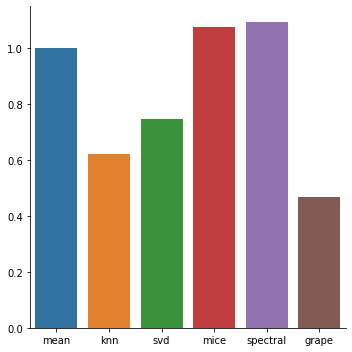

In [68]:
#Normalizamos mae y representamos
import seaborn as sns
df2=df
df2['mae']=df['mae']/df['mae']['mean']

g=sns.catplot(kind="bar", data=df2.T[:1])

# Predecimos Labels

In [69]:
#Pasamos los distintos parámetros del modelo        
parametros_modelo = {
    "model_types":'EGSAGE_EGSAGE',
    "norm_embs":None,
    "post_hiddens":None,
    "node_dim": 16,
    "edge_dim":16,
    "edge_mode":1,
    "gnn_activation":'relu',
    "concat_states":False,
    "dropout":0.,
    "aggr":'mean'
}    
device='cuda'

#Generamos el modelo y lo mostramos
model_y = get_gnn(data, paso_parametros(**parametros_modelo)).to(device)

# Imprimimos el modelo
print(model_y)

# Esta red neuronal asigna valores a los arcos
impute_hiddens=''
input_dim = parametros_modelo['node_dim'] * 2
output_dim = 1
impute_activation='relu'
impute_model_y = MLPNet(input_dim, output_dim,
                            hidden_layer_sizes=impute_hiddens,
                            hidden_activation=impute_activation,
                            dropout=parametros_modelo['dropout']).to(device)
print(impute_model_y)


# Esta red neuronal asigna valores de 'y'
n_row, n_col = data.df_X.shape
predict_hiddens = []
predict_model = MLPNet(n_col, 1,
                           hidden_layer_sizes=predict_hiddens,
                           dropout=parametros_modelo['dropout']).to(device)

print(predict_model)

['EGSAGE', 'EGSAGE'] [True, True] [16]
GNNStack(
  (convs): ModuleList(
    (0): EGraphSage(
      (message_lin): Linear(in_features=9, out_features=16, bias=True)
      (agg_lin): Linear(in_features=24, out_features=16, bias=True)
      (message_activation): ReLU()
      (update_activation): ReLU()
    )
    (1): EGraphSage(
      (message_lin): Linear(in_features=32, out_features=16, bias=True)
      (agg_lin): Linear(in_features=32, out_features=16, bias=True)
      (message_activation): ReLU()
      (update_activation): ReLU()
    )
  )
  (node_post_mlp): Sequential(
    (0): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (1): Linear(in_features=16, out_features=16, bias=True)
  )
  (edge_update_mlps): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=33, out_features=16, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=48, out_features=1

In [70]:
# Parametros a entrenar
trainable_parameters = list(model_y.parameters()) \
                           + list(impute_model_y.parameters()) \
                           + list(predict_model.parameters())

In [71]:
epochs=20000
known=0.7 #Probabilidad de conocer el valor del atributo del arco (rdrop=1-known)

In [72]:
# Cargamos los datos del modelo
x = data.x.clone().detach().to(device)
y = data.y.clone().detach().to(device)
edge_index = data.edge_index.clone().detach().to(device)
train_edge_index = data.train_edge_index.clone().detach().to(device)
train_edge_attr = data.train_edge_attr.clone().detach().to(device)

train_y_mask = data.train_y_mask.clone().detach().to(device)
test_y_mask = data.test_y_mask.clone().detach().to(device)
print("all y num is {}, train num is {}, test num is {}"\
                .format(
                train_y_mask.shape[0],torch.sum(train_y_mask),
                torch.sum(test_y_mask)))

all y num is 1030, train num is 689, test num is 341


In [73]:
#Parametros del optimizador.
parametros_opt = {
    "opt":'adam',
    "weight_decay":0.,
    "lr":0.001,
    "opt_scheduler":'none',
    "opt_decay_step":1000,
    "opt_decay_rate":0.9
} 


# build optimizer
scheduler, opt = build_optimizer(paso_parametros(**parametros_opt), trainable_parameters)



for epoch in range(epochs):
    model_y.train()
    impute_model_y.train()
    predict_model.train()

    known_mask = get_known_mask(known, int(train_edge_attr.shape[0] / 2)).to(device)
    double_known_mask = torch.cat((known_mask, known_mask), dim=0)
    known_edge_index, known_edge_attr = mask_edge(train_edge_index, train_edge_attr, double_known_mask, True)

    opt.zero_grad()
    x_embd = model_y(x, known_edge_attr, known_edge_index)
    X = impute_model_y([x_embd[edge_index[0, :int(n_row * n_col)]], x_embd[edge_index[1, :int(n_row * n_col)]]])
    X = torch.reshape(X, [n_row, n_col])
    pred = predict_model(X)[:, 0]
    pred_train = pred[train_y_mask]
    label_train = y[train_y_mask]

    loss = F.mse_loss(pred_train, label_train)
    if epoch%500==1:
        print(epoch,loss)
    loss.backward()
    opt.step()

1 tensor(1547.4951, device='cuda:0', grad_fn=<MseLossBackward>)
501 tensor(162.2447, device='cuda:0', grad_fn=<MseLossBackward>)
1001 tensor(139.5123, device='cuda:0', grad_fn=<MseLossBackward>)
1501 tensor(147.2539, device='cuda:0', grad_fn=<MseLossBackward>)
2001 tensor(142.3166, device='cuda:0', grad_fn=<MseLossBackward>)
2501 tensor(139.3578, device='cuda:0', grad_fn=<MseLossBackward>)
3001 tensor(141.4554, device='cuda:0', grad_fn=<MseLossBackward>)
3501 tensor(138.9312, device='cuda:0', grad_fn=<MseLossBackward>)
4001 tensor(133.9850, device='cuda:0', grad_fn=<MseLossBackward>)
4501 tensor(134.0546, device='cuda:0', grad_fn=<MseLossBackward>)
5001 tensor(137.8888, device='cuda:0', grad_fn=<MseLossBackward>)
5501 tensor(140.5211, device='cuda:0', grad_fn=<MseLossBackward>)
6001 tensor(138.5962, device='cuda:0', grad_fn=<MseLossBackward>)
6501 tensor(122.5134, device='cuda:0', grad_fn=<MseLossBackward>)
7001 tensor(146.2840, device='cuda:0', grad_fn=<MseLossBackward>)
7501 tensor(1

In [74]:
#Grabamos el modelo #### Dejamos comentado
torch.save(model.state_dict(), uci_path+'/concrete/saved_model/y_model.pt')
torch.save(impute_model.state_dict(), uci_path+'/concrete/saved_model/y_impute_model.pt')
torch.save(predict_model.state_dict(), uci_path+'/concrete/saved_model/y_predict_model.pt')

In [ ]:
#Cargamos el modelo
model.load_state_dict(torch.load(uci_path+'/housing/saved_model/y_model.pt'))
impute_model.load_state_dict(torch.load(uci_path+'/housing/saved_model/y_impute_model.pt'))
predict_model.load_state_dict(torch.load(uci_path+'/housing/saved_model/y_predict_model.pt'))

In [75]:
model_y.eval()
impute_model_y.eval()
predict_model.eval()
with torch.no_grad():
    x_embd = model_y(x, train_edge_attr, train_edge_index)
    X = impute_model_y([x_embd[edge_index[0, :int(n_row * n_col)]], x_embd[edge_index[1, :int(n_row * n_col)]]])
    X = torch.reshape(X, [n_row, n_col])
    pred = predict_model(X)[:, 0]
    pred_test = pred[test_y_mask]
    label_test = y[test_y_mask]
    mse = F.mse_loss(pred_test, label_test)
    test_rmse = np.sqrt(mse.item())
    l1 = F.l1_loss(pred_test, label_test)
    test_l1 = l1.item()

val_GRAPE_y=[test_l1, test_rmse]

In [76]:
print("MSE: {} RMSE: {} MAE: {}".format(mse.item(), test_rmse,test_l1))

MSE: 105.5803451538086 RMSE: 10.275229688615656 MAE: 7.76985502243042


In [77]:
# Vemos las primeras etiquetas real vs previstas
print(y[test_y_mask][0:5].tolist())
print(pred[test_y_mask][0:5].tolist())

[43.70000076293945, 36.45000076293945, 56.13999938964844, 40.560001373291016, 53.29999923706055]
[51.526432037353516, 42.06147766113281, 52.423709869384766, 47.10548400878906, 50.9073371887207]


In [78]:
from sklearn.linear_model import LinearRegression

In [79]:
y = data.y.detach().numpy()
train_y_mask = data.train_y_mask.clone().detach()
test_y_mask = data.test_y_mask.clone().detach()
y_train = y[train_y_mask]
y_test = y[test_y_mask]


val_baseline_y=[]
for method in ['mean', 'knn', 'mice', 'svd', 'spectral']:
    level = best_levels[method]
    #print("using best level {} for {}".format(level,method))
    X_filled = baseline_inpute(X_incomplete, method,level)
    reg = LinearRegression().fit(X_filled[train_y_mask, :], y_train)
    y_pred_test = reg.predict(X_filled[test_y_mask, :])
    rmse = np.sqrt(np.mean((y_pred_test - y_test) ** 2))
    mae = np.mean(np.abs(y_pred_test - y_test))
    val_baseline_y.append([mae, rmse])

# Añadimos los valores de grape
val_baseline_y.append(val_GRAPE_y)

[SoftImpute] Max Singular Value of X_init = 23.897300
[SoftImpute] Iter 1: observed MAE=0.012911 rank=8
[SoftImpute] Iter 2: observed MAE=0.012953 rank=8
[SoftImpute] Iter 3: observed MAE=0.012995 rank=8
[SoftImpute] Iter 4: observed MAE=0.013035 rank=8
[SoftImpute] Iter 5: observed MAE=0.013074 rank=8
[SoftImpute] Iter 6: observed MAE=0.013111 rank=8
[SoftImpute] Iter 7: observed MAE=0.013147 rank=8
[SoftImpute] Iter 8: observed MAE=0.013180 rank=8
[SoftImpute] Iter 9: observed MAE=0.013212 rank=8
[SoftImpute] Iter 10: observed MAE=0.013242 rank=8
[SoftImpute] Iter 11: observed MAE=0.013270 rank=8
[SoftImpute] Iter 12: observed MAE=0.013296 rank=8
[SoftImpute] Iter 13: observed MAE=0.013321 rank=8
[SoftImpute] Iter 14: observed MAE=0.013345 rank=8
[SoftImpute] Iter 15: observed MAE=0.013367 rank=8
[SoftImpute] Iter 16: observed MAE=0.013388 rank=8
[SoftImpute] Iter 17: observed MAE=0.013408 rank=8
[SoftImpute] Iter 18: observed MAE=0.013427 rank=8
[SoftImpute] Iter 19: observed MAE=0.

/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [80]:
df=pd.DataFrame(val_baseline_y, columns=['mae','rmse'], index=['mean', 'knn', 'svd', 'mice', 'spectral','grape'])
df

,mae,rmse
mean,10.515912,13.104135
knn,9.992220,12.430884
svd,10.274352,12.890592
mice,11.098787,13.665906
spectral,10.738141,13.360426
grape,7.769855,10.275230


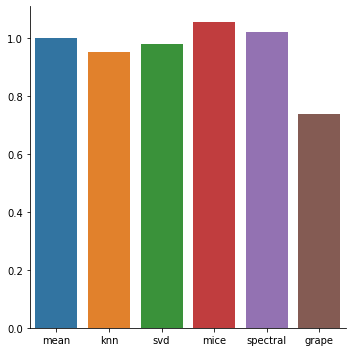

In [81]:
df2=df
df2['mae']=df['mae']/df['mae']['mean']

g=sns.catplot(kind="bar", data=df2.T[:1])

# Perfecto!!!!